In [24]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from prophet import Prophet


In [25]:
# Load Data
file_path = 'yahoo_data.xlsx'
df = pd.read_excel(file_path)

df.rename(columns={'Close*': 'Close'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df.set_index('Date', inplace=True)

In [26]:
df['SMA_20'] = df['Close'].rolling(window=20).mean()
df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()
df['STD_20'] = df['Close'].rolling(window=20).std()
df['Upper_Band'] = df['SMA_20'] + (df['STD_20'] * 2)
df['Lower_Band'] = df['SMA_20'] - (df['STD_20'] * 2)

iso_model = IsolationForest(contamination=0.01, random_state=42)
df['anomaly_iforest'] = iso_model.fit_predict(df[['Close']])
df['is_anomaly'] = df['anomaly_iforest'] == -1

In [27]:
# Prophet
prophet_df = df[['Close']].reset_index().rename(columns={'Date': 'ds', 'Close': 'y'})
model = Prophet(daily_seasonality=True)
model.fit(prophet_df)

future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)



10:51:06 - cmdstanpy - INFO - Chain [1] start processing
10:51:08 - cmdstanpy - INFO - Chain [1] done processing


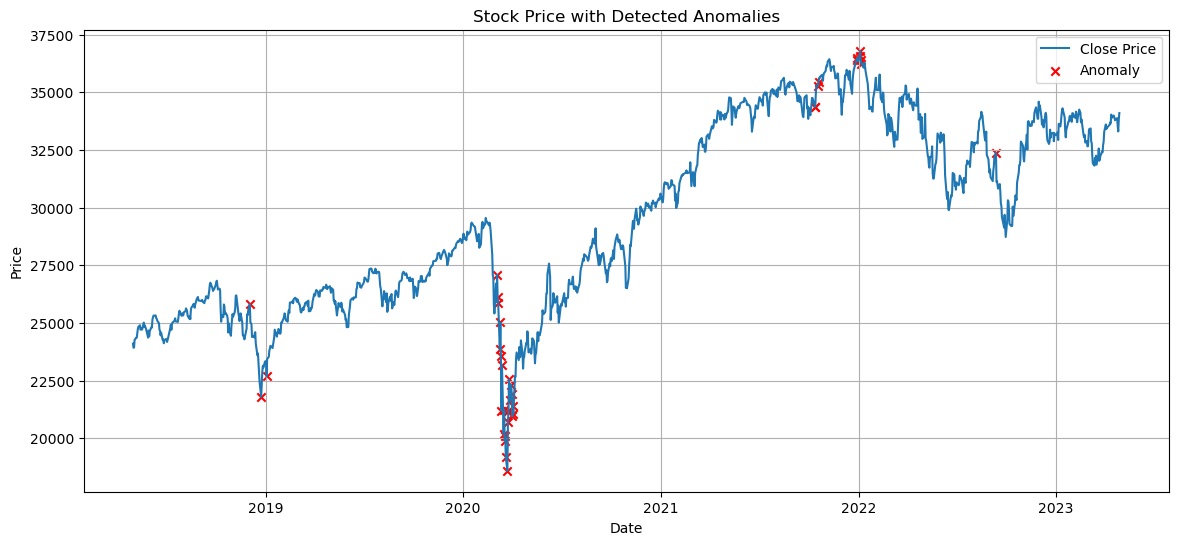

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(df.index, df['Close'], label='Close Price')
plt.scatter(df[df['anomaly'] == 'Anomaly'].index, df[df['anomaly'] == 'Anomaly']['Close'],
            color='red', label='Anomaly', marker='x')
plt.title('Stock Price with Detected Anomalies')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [28]:

forecasted = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
merged = pd.merge(prophet_df, forecasted, on='ds', how='left')
merged['anomaly_prophet'] = (merged['y'] > merged['yhat_upper']) | (merged['y'] < merged['yhat_lower'])


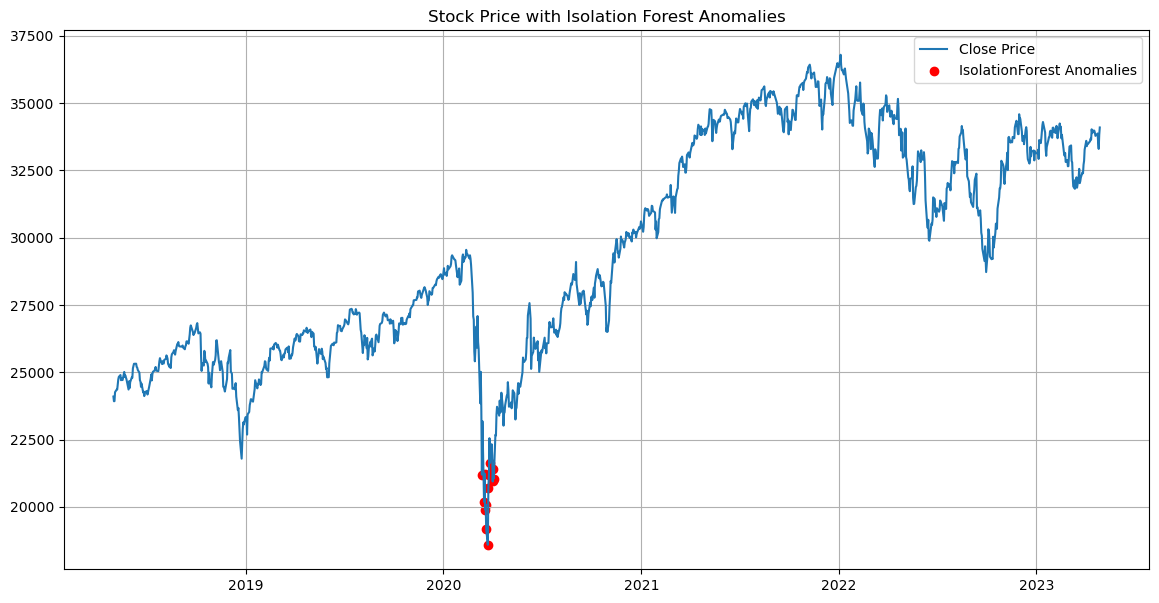

In [29]:
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Close'], label='Close Price')
plt.scatter(df.index[df['is_anomaly']], df['Close'][df['is_anomaly']], color='red', label='IsolationForest Anomalies')
plt.title("Stock Price with Isolation Forest Anomalies")
plt.legend()
plt.grid(True)
plt.show()

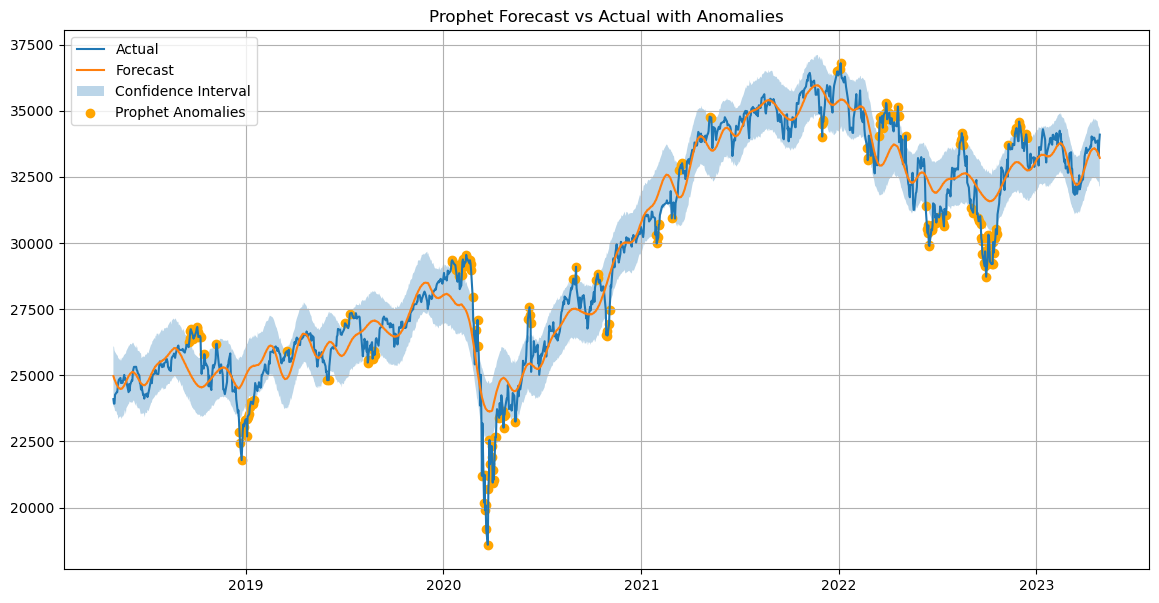

In [30]:
plt.figure(figsize=(14, 7))
plt.plot(merged['ds'], merged['y'], label='Actual')
plt.plot(merged['ds'], merged['yhat'], label='Forecast')
plt.fill_between(merged['ds'], merged['yhat_lower'], merged['yhat_upper'], alpha=0.3, label='Confidence Interval')
plt.scatter(merged['ds'][merged['anomaly_prophet']], merged['y'][merged['anomaly_prophet']], color='orange', label='Prophet Anomalies')
plt.title("Prophet Forecast vs Actual with Anomalies")
plt.legend()
plt.grid(True)
plt.show()

In [31]:
import pandas as pd

# Load the Excel file
file_path = 'yahoo_data.xlsx'
df = pd.read_excel(file_path)

# Preview data
print(df.head())

# Ensure 'Date' column is datetime
df['Date'] = pd.to_datetime(df['Date'])

# Set 'Date' as index
df.set_index('Date', inplace=True)

# Drop any rows with missing values
df.dropna(inplace=True)


           Date      Open      High       Low    Close*  Adj Close**  \
0  Apr 28, 2023  33797.43  34104.56  33728.40  34098.16     34098.16   
1  Apr 27, 2023  33381.66  33859.75  33374.65  33826.16     33826.16   
2  Apr 26, 2023  33596.34  33645.83  33235.85  33301.87     33301.87   
3  Apr 25, 2023  33828.34  33875.49  33525.39  33530.83     33530.83   
4  Apr 24, 2023  33805.04  33891.15  33726.09  33875.40     33875.40   

      Volume  
0  354310000  
1  343240000  
2  321170000  
3  297880000  
4  252020000  


In [33]:
# Clean column names
df.columns = df.columns.str.replace(r'[*]+', '', regex=True).str.strip()

# Now use 'Close' safely
df['SMA_20'] = df['Close'].rolling(window=20).mean()
df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()


# Relative Strength Index (RSI)
delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

# Bollinger Bands
df['BB_Upper'] = df['SMA_20'] + 2 * df['Close'].rolling(window=20).std()
df['BB_Lower'] = df['SMA_20'] - 2 * df['Close'].rolling(window=20).std()


In [34]:
from sklearn.ensemble import IsolationForest

# Select features
features = df[['Close', 'SMA_20', 'EMA_20', 'RSI']].dropna()

# Fit Isolation Forest
model = IsolationForest(contamination=0.03, random_state=42)
df.loc[features.index, 'anomaly'] = model.fit_predict(features)

# Convert -1 to 'Anomaly', 1 to 'Normal'
df['anomaly'] = df['anomaly'].map({1: 'Normal', -1: 'Anomaly'})


In [35]:
from prophet import Prophet

# Prepare data for Prophet
prophet_df = df[['Close']].reset_index().rename(columns={'Date': 'ds', 'Close': 'y'})

# Fit Prophet
m = Prophet(daily_seasonality=True)
m.fit(prophet_df)

# Create future dataframe
future = m.make_future_dataframe(periods=30)
forecast = m.predict(future)

# Optional: plot forecast
#m.plot(forecast)


10:55:38 - cmdstanpy - INFO - Chain [1] start processing
10:55:40 - cmdstanpy - INFO - Chain [1] done processing


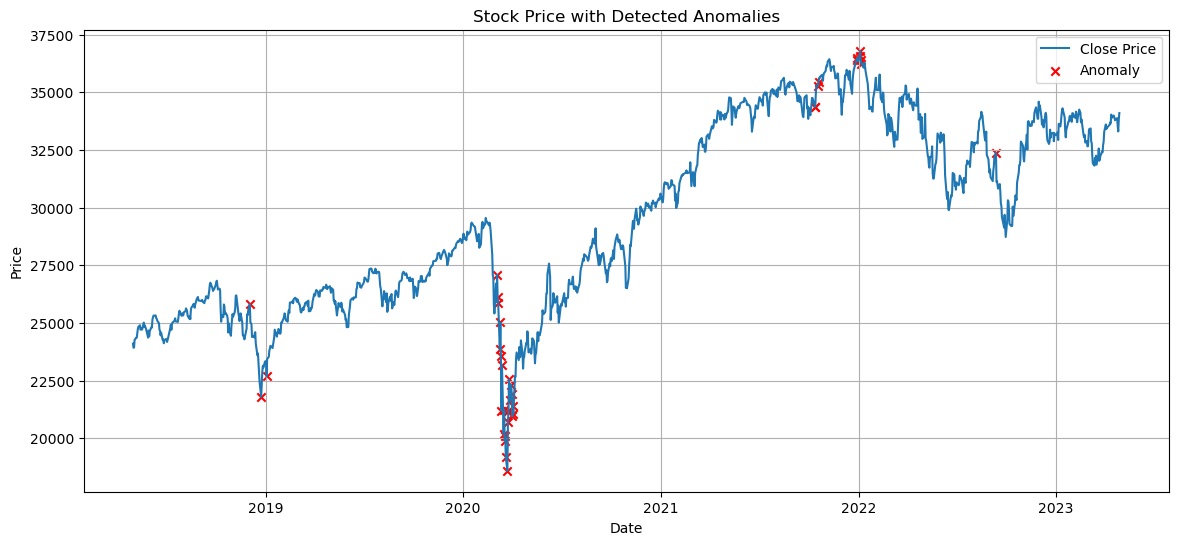

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(df.index, df['Close'], label='Close Price')
plt.scatter(df[df['anomaly'] == 'Anomaly'].index, df[df['anomaly'] == 'Anomaly']['Close'],
            color='red', label='Anomaly', marker='x')
plt.title('Stock Price with Detected Anomalies')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()
